In [3]:
%cd /content/gdrive/MyDrive/MLP

/content/gdrive/MyDrive/MLP


In [6]:

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of learners
n = 2000

# Generate synthetic data
age = np.random.randint(12, 20, n)  # ages 12 to 19
gender = np.random.choice(["Male", "Female"], n)
province = np.random.choice(
    [
        "Gauteng",
        "KwaZulu-Natal",
        "Western Cape",
        "Eastern Cape",
        "Limpopo",
        "Mpumalanga",
        "North West",
        "Northern Cape",
        "Free State",
    ],
    n,
)
urban_rural = np.random.choice(["Urban", "Rural"], n, p=[0.6, 0.4])
household_income = np.random.normal(8000, 4000, n).clip(0)  # rand income
parent_education = np.random.choice(
    ["None", "Primary", "Secondary", "Tertiary"], n, p=[0.1, 0.3, 0.4, 0.2]
)
attendance = np.random.choice(["Yes", "No"], n, p=[0.85, 0.15])
highest_grade = np.where(
    attendance == "Yes", np.random.randint(1, 12, n), np.random.randint(1, 10, n)
)

# Define dropout label: dropout = not attending school but age < 18
dropout = np.where((attendance == "No") & (age < 18), 1, 0)

# Build DataFrame
df = pd.DataFrame(
    {
        "age": age,
        "gender": gender,
        "province": province,
        "urban_rural": urban_rural,
        "household_income": household_income.round(2),
        "parent_education": parent_education,
        "attendance": attendance,
        "highest_grade": highest_grade,
        "dropout": dropout,
    }
)

# Introduce missing values (about 7%)
for col in ["household_income", "parent_education", "attendance"]:
    df.loc[df.sample(frac=0.07, random_state=42).index, col] = np.nan

# Add noise / outliers
# 1. Extreme household incomes (too high or negative)
outlier_idx = np.random.choice(
    df.index, size=int(0.02 * n), replace=False
)  # 2% outliers
df.loc[outlier_idx, "household_income"] = np.random.choice(
    [1e6, -5000], size=len(outlier_idx)
)

# 2. Unrealistic ages (too young or too old for school)
age_outliers = np.random.choice(
    df.index, size=int(0.01 * n), replace=False
)  # 1% outliers
df.loc[age_outliers, "age"] = np.random.choice([5, 30], size=len(age_outliers))

# 3. Attendance inconsistencies (e.g., dropout=1 but marked as 'Yes')
attend_outliers = np.random.choice(df.index, size=int(0.01 * n), replace=False)
df.loc[attend_outliers, "attendance"] = "Yes"
df.loc[attend_outliers, "dropout"] = 1  # force inconsistency

# Save CSV
df.to_csv("school_dropout_sa_with_noise.csv", index=False)

print(
    "Dataset generated with missing values + noise/outliers saved as 'school_dropout_sa_with_noise.csv'"
)
print(df.describe(include="all"))
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset generated with missing values + noise/outliers saved as 'school_dropout_sa_with_noise.csv'
                age  gender       province urban_rural  household_income  \
count   2000.000000    2000           2000        2000       1861.000000   
unique          NaN       2              9           2               NaN   
top             NaN  Female  Northern Cape       Urban               NaN   
freq            NaN    1023            238        1227               NaN   
mean      15.414500     NaN            NaN         NaN      18924.217157   
std        2.563782     NaN            NaN         NaN     104920.226000   
min        5.000000     NaN            NaN         NaN      -5000.000000   
25%       13.000000     NaN            NaN         NaN       5066.930000   
50%       15.000000     NaN            NaN         NaN       7838.990000   
75%       17.000000     NaN            NaN         NaN      10568.100000   
max       30.000000     NaN            NaN         NaN    1000000

In [5]:
df.head()

,age,gender,province,urban_rural,household_income,parent_education,attendance,highest_grade,dropout
0,18,Male,North West,Urban,8931.49,Secondary,Yes,2,0
1,15,Female,Western Cape,Urban,-5000.00,Primary,Yes,9,0
2,5,Female,North West,Rural,4164.10,Secondary,Yes,8,0
3,18,Female,Northern Cape,Urban,11491.67,Primary,No,7,0
4,14,Female,Mpumalanga,Rural,13799.41,Secondary,Yes,2,0


Dataset shape: (2000, 9)

Missing values per column:
age                   0
gender                0
province              0
urban_rural           0
household_income    139
parent_education    315
attendance          139
highest_grade         0
dropout               0
dtype: int64

Data types:
age                   int64
gender               object
province             object
urban_rural          object
household_income    float64
parent_education     object
attendance           object
highest_grade         int64
dropout               int64
dtype: object


,age,household_income,highest_grade,dropout
count,2000.000000,1861.000000,2000.00000,2000.000000
mean,15.414500,18924.217157,5.75450,0.133500
std,2.563782,104920.226000,3.11594,0.340199
min,5.000000,-5000.000000,1.00000,0.000000
25%,13.000000,5066.930000,3.00000,0.000000
50%,15.000000,7838.990000,6.00000,0.000000
75%,17.000000,10568.100000,8.00000,0.000000
max,30.000000,1000000.000000,11.00000,1.000000


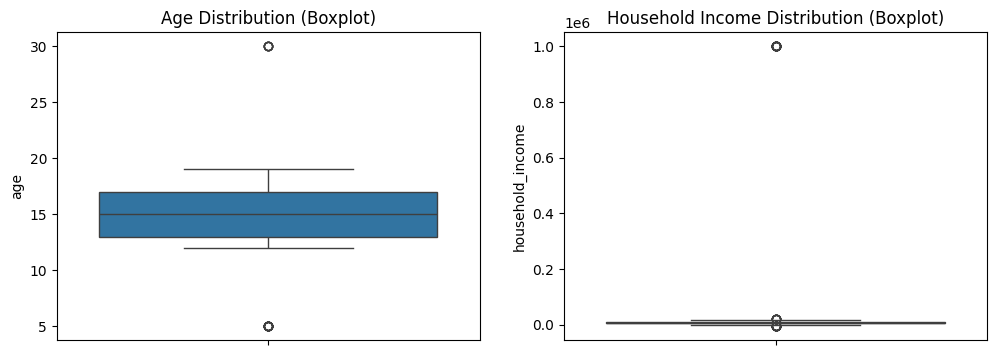


gender value counts:
gender
Female    1023
Male       977
Name: count, dtype: int64

province value counts:
province
Northern Cape    238
Gauteng          236
Mpumalanga       235
Western Cape     231
Free State       222
Eastern Cape     218
Limpopo          213
North West       206
KwaZulu-Natal    201
Name: count, dtype: int64

urban_rural value counts:
urban_rural
Urban    1227
Rural     773
Name: count, dtype: int64

parent_education value counts:
parent_education
Secondary    765
Primary      563
Tertiary     357
NaN          315
Name: count, dtype: int64

attendance value counts:
attendance
Yes    1565
No      296
NaN     139
Name: count, dtype: int64
Inconsistent records: 267 dropout=1 entries; 1704 attendances marked 'Yes'
Training size: (1200, 8), Validation: (400, 8), Test: (400, 8)
0:	test: 0.9382359	best: 0.9382359 (0)	total: 3.27ms	remaining: 1.3s
100:	test: 0.9714194	best: 0.9720617 (30)	total: 117ms	remaining: 345ms
200:	test: 0.9740955	best: 0.9745237 (171)	total: 221

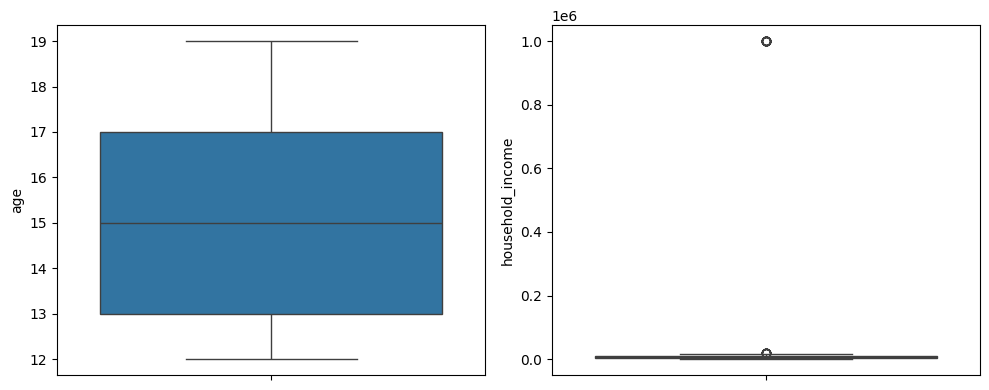

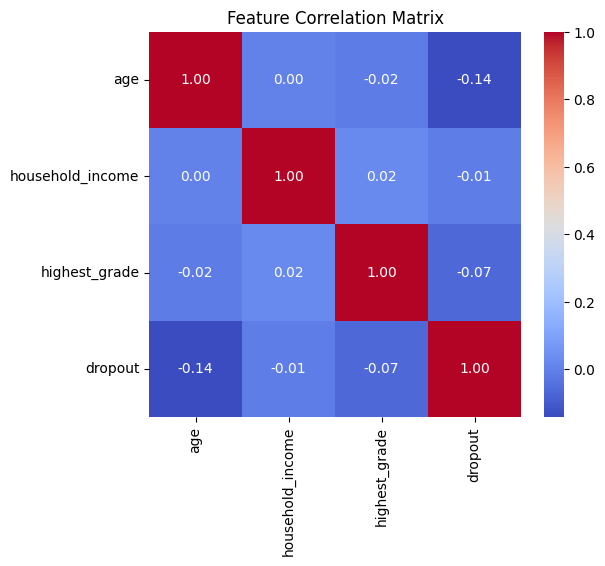

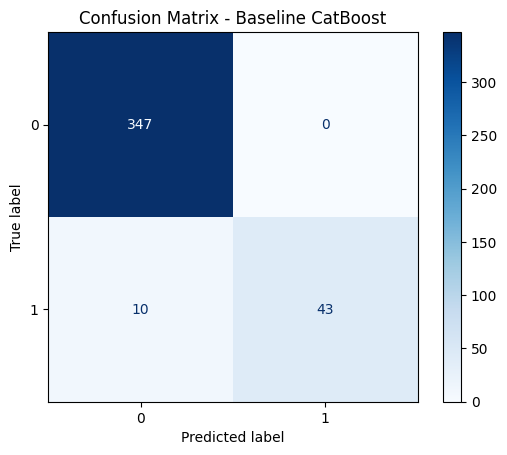

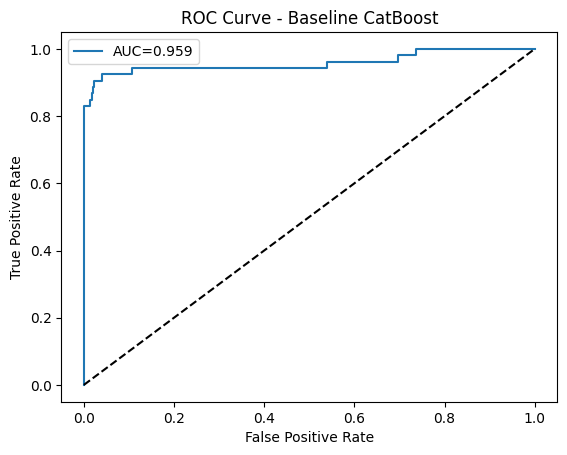

In [11]:


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv("school_dropout_sa_with_noise.csv")
print(f"Dataset shape: {df.shape}")
df.head()

# Check missingness and data types
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)

# Quick numerical summary
display(df.describe())

# Outlier detection (age and household_income)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(y=df['age'], ax=ax[0])
ax[0].set_title('Age Distribution (Boxplot)')
sns.boxplot(y=df['household_income'], ax=ax[1])
ax[1].set_title('Household Income Distribution (Boxplot)')
plt.show()

# Categorical summaries
for col in ['gender', 'province', 'urban_rural', 'parent_education', 'attendance']:
    print(f"\n{col} value counts:")
    print(df[col].value_counts(dropna=False))

# School-age learners typically between 6 and 20
df.loc[(df['age'] < 6) | (df['age'] > 20), 'age'] = np.nan

# b) Handle income issues
# Negative incomes are invalid; cap upper outliers at 99th percentile
df.loc[df['household_income'] < 0, 'household_income'] = np.nan
upper_cap = df['household_income'].quantile(0.99)
df['household_income'] = np.where(df['household_income'] > upper_cap, upper_cap, df['household_income'])

# c) Impute missing numeric and categorical values
df['household_income'].fillna(df['household_income'].median(), inplace=True)
for cat in ['parent_education', 'attendance']:
    df[cat].fillna(df[cat].mode()[0], inplace=True)

# d) Logical consistency check: if dropout == 1 → attendance should not be 'Yes'
# We assume attendance records may be inconsistent, correct them conservatively
mask_inconsistent = (df['dropout'] == 1) & (df['attendance'] == 'Yes')
# retain inconsistencies; they may reflect reporting noise
print(f"Inconsistent records: {(df['dropout'] == 1).sum()} dropout=1 entries; {(df['attendance'] == 'Yes').sum()} attendances marked 'Yes'")


target = 'dropout'
features = [c for c in df.columns if c != target]
cat_features = ['gender', 'province', 'urban_rural', 'parent_education', 'attendance']

X = df[features]
y = df[target]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print(f"Training size: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=100
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(y=df['age'], ax=ax[0])
sns.boxplot(y=df['household_income'], ax=ax[1])
plt.tight_layout()

corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")




print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Baseline CatBoost')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_pred_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline CatBoost')
plt.legend()
plt.show()


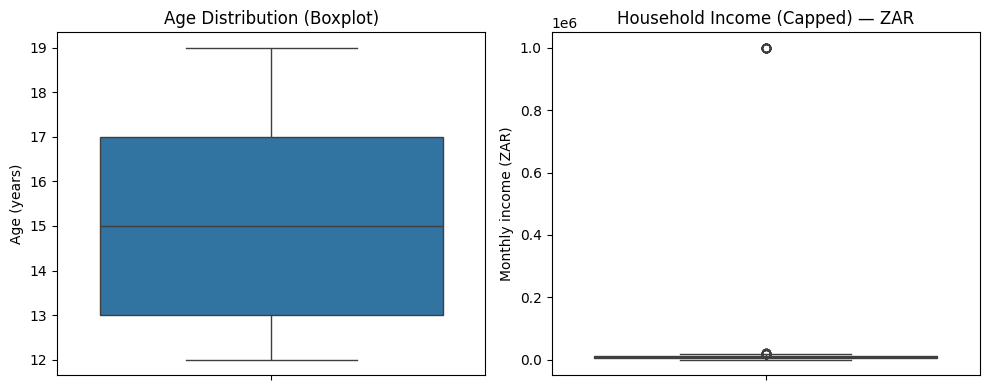

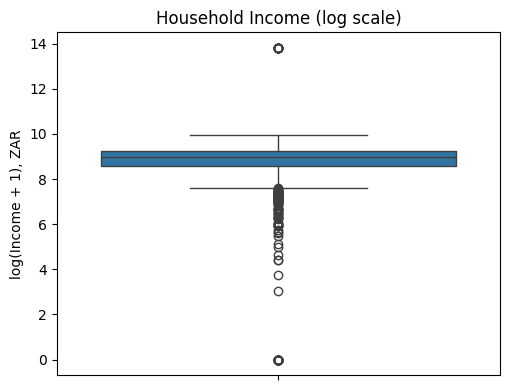

In [12]:

# --- 1) Prepare capped income for cleaner visuals ---
upper_cap = df['household_income'].quantile(0.99)  # winsorize at 99th percentile
df['household_income_capped'] = np.where(
    df['household_income'] > upper_cap, upper_cap, df['household_income']
)

# --- 2) Side-by-side boxplots: Age + Capped Income (ZAR) ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['age'])
plt.title("Age Distribution (Boxplot)")
plt.ylabel("Age (years)")

plt.subplot(1, 2, 2)
sns.boxplot(y=df['household_income_capped'])
plt.title("Household Income (Capped) — ZAR")
plt.ylabel("Monthly income (ZAR)")
plt.tight_layout()

# --- 3) Optional: Log-scale income boxplot for appendix/supplement ---
plt.figure(figsize=(5.2, 4))
sns.boxplot(y=np.log1p(df['household_income']))  # log(Income + 1)
plt.title("Household Income (log scale)")
plt.ylabel("log(Income + 1), ZAR")
plt.tight_layout()

In [13]:

# Separate numeric and categorical features
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns

# Describe numeric
num_summary = df[numeric_cols].describe().T[['mean', 'std', 'min', 'max']]
num_summary['missing_values'] = df[numeric_cols].isnull().sum()

# Describe categorical
cat_summary = pd.DataFrame({
    'unique_values': df[categorical_cols].nunique(),
    'most_frequent': df[categorical_cols].mode().iloc[0],
    'missing_values': df[categorical_cols].isnull().sum()
})

# Combine summary
num_summary['type'] = 'Numeric'
cat_summary['type'] = 'Categorical'

summary_table = pd.concat([num_summary, cat_summary], axis=0, sort=False)
summary_table = summary_table.fillna('-')
summary_table = summary_table[['type', 'mean', 'std', 'min', 'max', 'unique_values', 'most_frequent', 'missing_values']]
summary_table


,type,mean,std,min,max,unique_values,most_frequent,missing_values
age,Numeric,15.456566,2.297401,12.0,19.0,-,-,20
household_income,Numeric,18279.74627,101225.32349,0.0,1000000.0,-,-,0
highest_grade,Numeric,5.7545,3.11594,1.0,11.0,-,-,0
dropout,Numeric,0.1335,0.340199,0.0,1.0,-,-,0
household_income_capped,Numeric,18279.74627,101225.32349,0.0,1000000.0,-,-,0
gender,Categorical,-,-,-,-,2.0,Female,0
province,Categorical,-,-,-,-,9.0,Northern Cape,0
urban_rural,Categorical,-,-,-,-,2.0,Urban,0
parent_education,Categorical,-,-,-,-,3.0,Secondary,0
attendance,Categorical,-,-,-,-,2.0,Yes,0


In [15]:
summary_table.to_latex('feature_summary_table.tex', index=True, float_format="%.2f")


## XAI stuff

In [16]:

from typing import Any
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder


import shap

if 'feature_names' not in globals():
    feature_names = list[Any](X_test.columns)

# Pick a small evaluation slice for SHAP speed (adjust as needed)
SHAP_SAMPLE = min(800, len(X_test))
X_eval = X_test.iloc[:SHAP_SAMPLE].copy()
y_eval = y_test.iloc[:SHAP_SAMPLE].copy() if hasattr(y_test, 'iloc') else y_test[:SHAP_SAMPLE]

# Predicted probabilities and labels (using default threshold 0.5)
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)



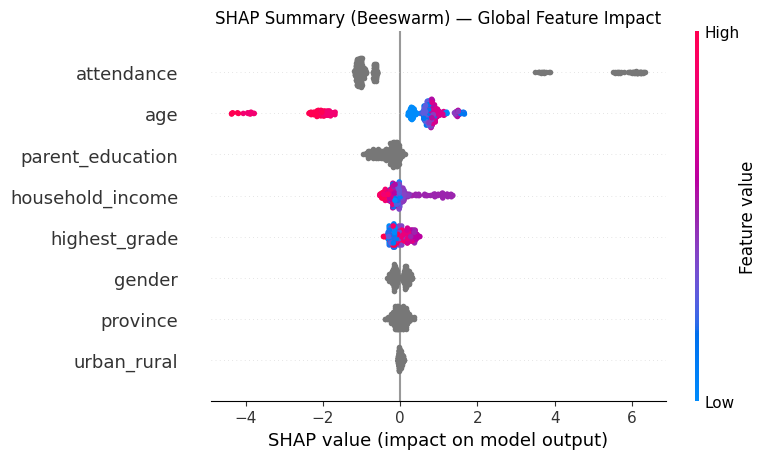

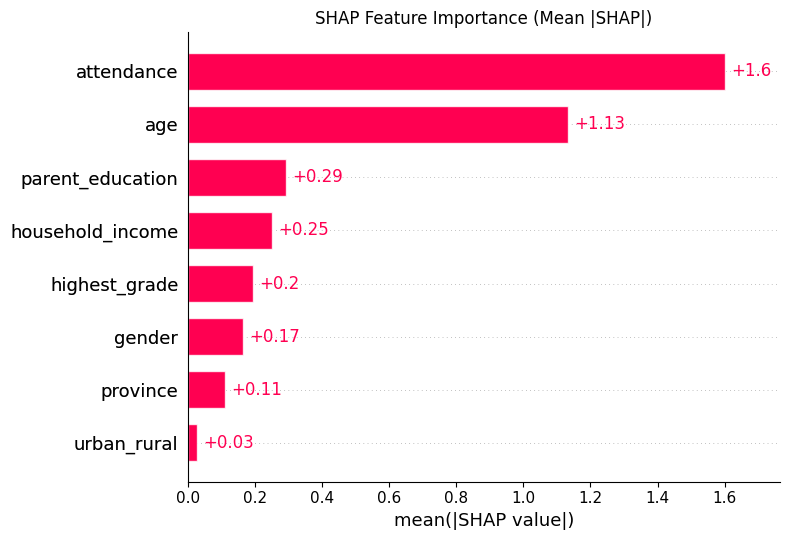

In [17]:
use_legacy = False
explanation = None
try:
    explainer = shap.Explainer(model)
    explanation = explainer(X_eval)
except Exception as e:
    print(
        "Modern SHAP Explainer failed; falling back to TreeExplainer. Reason:", str(e)
    )
    use_legacy = True

plt.close("all")

if not use_legacy:
    # Beeswarm (global summary)
    shap.plots.beeswarm(explanation, show=False, max_display=20)
    plt.title("SHAP Summary (Beeswarm) — Global Feature Impact")
    plt.tight_layout()

    plt.show()

    # Mean |SHAP| bar
    shap.plots.bar(explanation, show=False, max_display=20)
    plt.title("SHAP Feature Importance (Mean |SHAP|)")
    plt.tight_layout()

    plt.show()

else:
    # Legacy path
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval)

    # Beeswarm
    shap.summary_plot(shap_values, X_eval, plot_type="dot", show=False, max_display=20)
    plt.title("SHAP Summary (Beeswarm) — Global Feature Impact")
    plt.tight_layout()

    plt.show()

    # Mean |SHAP| bar
    shap.summary_plot(shap_values, X_eval, plot_type="bar", show=False, max_display=20)
    plt.title("SHAP Feature Importance (Mean |SHAP|)")
    plt.tight_layout()
    plt.show()

Top features for dependence plots: ['attendance', 'age', 'parent_education']


<Figure size 640x480 with 0 Axes>

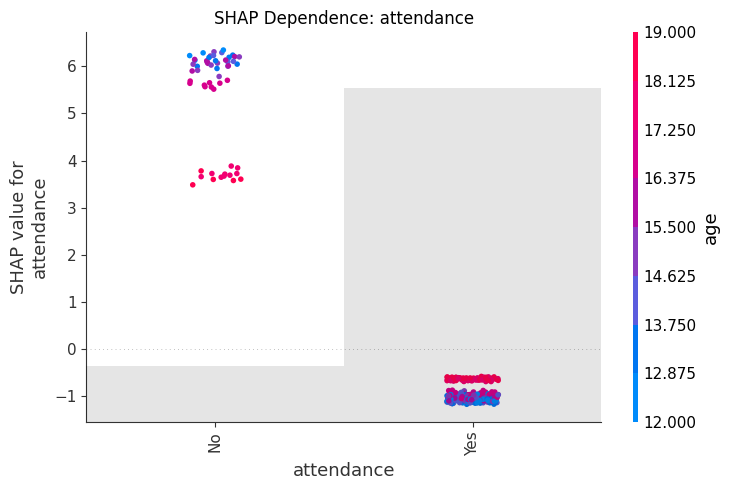

<Figure size 640x480 with 0 Axes>

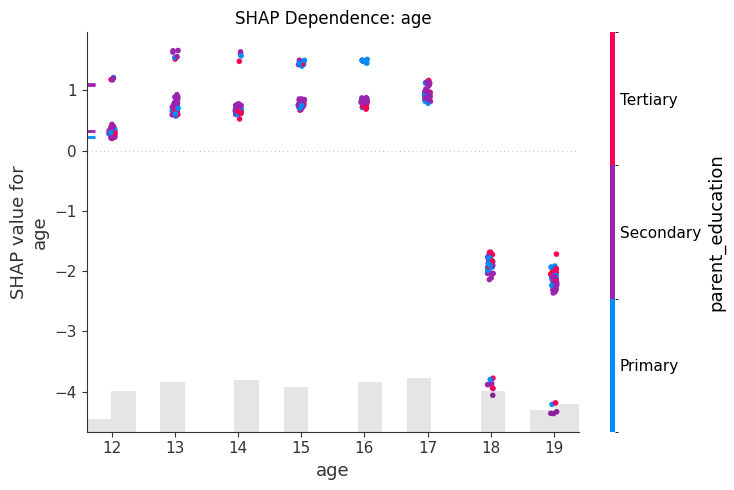

<Figure size 640x480 with 0 Axes>

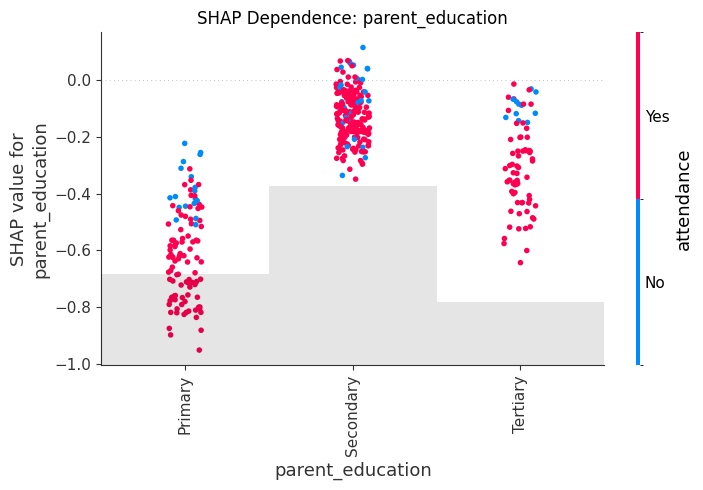

In [18]:
# Cell 2: SHAP dependence plots for top 3 features

def get_top_features_from_explanation(explanation, top_k=3):
    # Works for modern Explanation
    mean_abs = np.mean(np.abs(explanation.values), axis=0)
    order = np.argsort(-mean_abs)[:top_k]
    return [explanation.feature_names[i] for i in order]

def get_top_features_legacy(shap_values, df, top_k=3):
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    order = np.argsort(-mean_abs)[:top_k]
    return [df.columns[i] for i in order]

plt.close('all')

if 'explanation' in globals() and explanation is not None and not use_legacy:
    top3 = get_top_features_from_explanation(explanation, 3)
else:
    # Legacy path
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval)
    top3 = get_top_features_legacy(shap_values, X_eval, 3)

print("Top features for dependence plots:", top3)

# Dependence plots (use color_by next strongest feature automatically)
if not use_legacy:
    for i, feat in enumerate(top3):
        plt.figure()
        shap.plots.scatter(explanation[:, feat], color=explanation[:, top3[(i+1) % len(top3)]], show=False)
        plt.title(f"SHAP Dependence: {feat}")
        plt.tight_layout()
        plt.show()
else:
    for i, feat in enumerate(top3):
        # For legacy: choose interaction feature as next top feature
        interaction = top3[(i+1) % len(top3)] if len(top3) > 1 else None
        shap.dependence_plot(
            feat, shap_values, X_eval, interaction_index=interaction, show=False
        )
        plt.title(f"SHAP Dependence: {feat}")
        plt.tight_layout()
        plt.show()



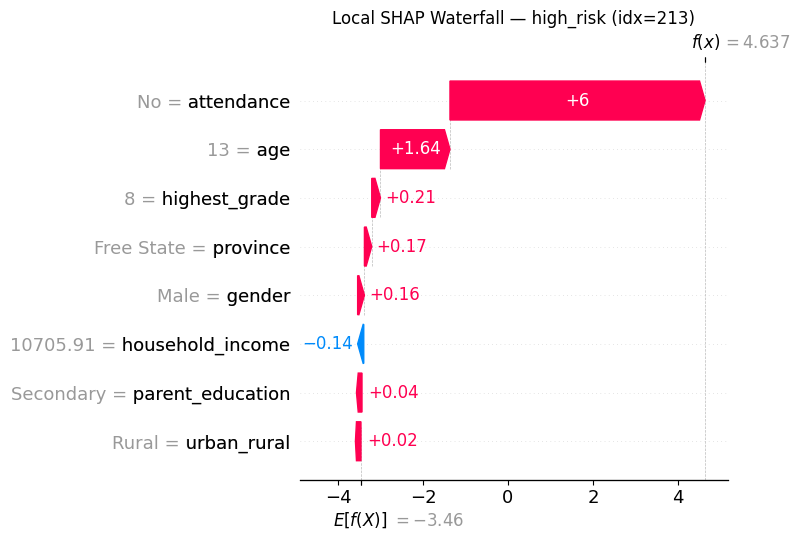

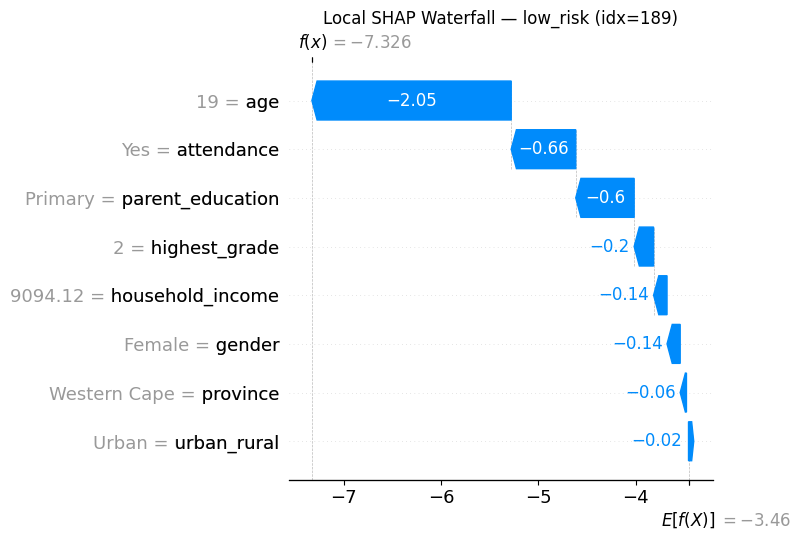

In [22]:
# Cell 3: Local SHAP explanations for 2 individual students
# Strategy: pick one positive prediction (high risk) and one negative prediction (low risk)

# Identify a high-risk and low-risk index
high_idx = int(np.argmax(y_proba))     # most confident dropout
low_idx  = int(np.argmin(y_proba))     # most confident completion

instances = [("high_risk", high_idx), ("low_risk", low_idx)]

plt.close('all')

if not use_legacy:
    explainer = shap.Explainer(model)
    for label, idx in instances:
        row = X_test.iloc[[idx]]
        exp = explainer(row)

        # Waterfall plot
        shap.plots.waterfall(exp[0], show=False, max_display=20)
        plt.title(f"Local SHAP Waterfall — {label} (idx={idx})")
        plt.tight_layout()
        plt.show()
else:
    # Legacy waterfall is trickier; use force plot and save with matplotlib
    explainer = shap.TreeExplainer(model)
    # NOTE: force_plot saving needs shap.plots._force; we'll render as decision plot instead
    for label, idx in instances:
        row = X_test.iloc[[idx]]
        shap_values = explainer.shap_values(row)
        base = explainer.expected_value

        # Decision plot (works with legacy values)
        shap.decision_plot(
            base, shap_values, row, feature_display_range=slice(None, 20), show=False
        )
        plt.title(f"Local SHAP Decision Plot — {label} (idx={idx})")
        plt.tight_layout()
        plt.show()




In [27]:
# Cell 4 (FINAL): Fairness / subgroup analysis (robust)

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# --- Build evaluation frame cleanly ---
df_eval = X_test.copy()

# Attach ground truth, predictions, and probabilities
df_eval = df_eval.assign(
    true=(y_test.values if hasattr(y_test, "values") else np.asarray(y_test)),
    pred=y_pred,
    proba=y_proba
)

# Reset index so groupby indices are safe to slice positionally if ever needed
df_eval = df_eval.reset_index(drop=True)

# Ensure the three grouping columns exist; if not, warn and skip
candidate_groups = ["gender", "urban_rural", "province"]
group_cols = []
for col in candidate_groups:
    if col in df_eval.columns:
        group_cols.append(col)
    else:
        print(f"Warning: '{col}' not found in X_test columns; skipping.")

# If a grouping column has NaNs, fill with explicit label for clarity
for gcol in group_cols:
    if df_eval[gcol].isna().any():
        df_eval[gcol] = df_eval[gcol].astype(object).fillna("MISSING")

# Cast grouping columns to string to avoid category/numeric label mismatches
for gcol in group_cols:
    df_eval[gcol] = df_eval[gcol].astype(str)

def metrics_by_group_df(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    """
    Compute precision, recall, f1, AUC, support, positives for each subgroup in group_col.
    - Works directly on DataFrame slices (no fragile numpy indexing).
    - AUC is NaN if a subgroup has only one class in y_true.
    """
    rows = []
    for g, sdf in df.groupby(group_col, dropna=False):
        yt = sdf["true"].to_numpy()
        yp = sdf["pred"].to_numpy()
        yp_prob = sdf["proba"].to_numpy()

        support = int(yt.size)
        positives = int((yt == 1).sum())

        # Precision/Recall/F1 (binary average, with safe zero handling)
        p, r, f1, _ = precision_recall_fscore_support(
            yt, yp, average="binary", zero_division=0
        )

        # AUC only if both classes present
        auc = np.nan
        if np.unique(yt).size > 1:
            try:
                auc = float(roc_auc_score(yt, yp_prob))
            except Exception:
                auc = np.nan

        rows.append(
            {
                group_col: str(g),
                "support": support,
                "positives": positives,
                "precision": float(p),
                "recall": float(r),
                "f1": float(f1),
                "auc": auc,
            }
        )

    out = pd.DataFrame(rows).sort_values(group_col).reset_index(drop=True)
    return out

# Build fairness tables for each available grouping column
fairness_tables = {}
for gcol in group_cols:
    fairness_tables[gcol] = metrics_by_group_df(df_eval, gcol)

# Show the tables (prints nicely in Jupyter)
fairness_tables

{'gender':    gender  support  positives  precision    recall        f1       auc
 0  Female      220         28        1.0  0.785714  0.880000  0.948103
 1    Male      180         25        1.0  0.840000  0.913043  0.972129,
 'urban_rural':   urban_rural  support  positives  precision    recall        f1       auc
 0       Rural      149         19        1.0  0.842105  0.914286  0.958704
 1       Urban      251         34        1.0  0.794118  0.885246  0.959067,
 'province':         province  support  positives  precision    recall        f1       auc
 0   Eastern Cape       45          9        1.0  0.777778  0.875000  0.950617
 1     Free State       46          3        1.0  1.000000  1.000000  1.000000
 2        Gauteng       42          6        1.0  0.833333  0.909091  0.995370
 3  KwaZulu-Natal       41          4        1.0  0.250000  0.400000  0.648649
 4        Limpopo       39          5        1.0  0.800000  0.888889  1.000000
 5     Mpumalanga       52          9      

<Figure size 640x480 with 0 Axes>

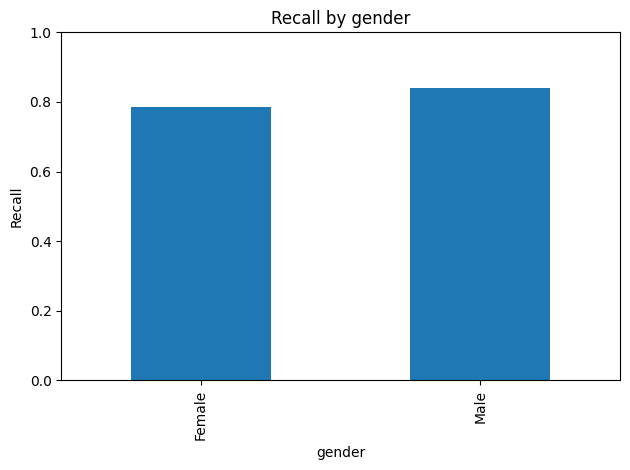

<Figure size 640x480 with 0 Axes>

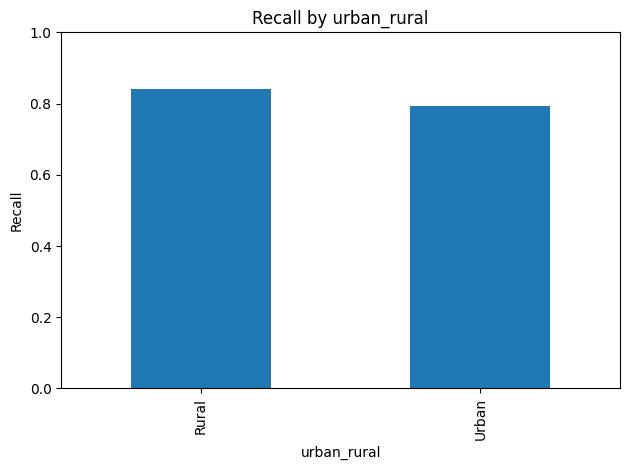

<Figure size 640x480 with 0 Axes>

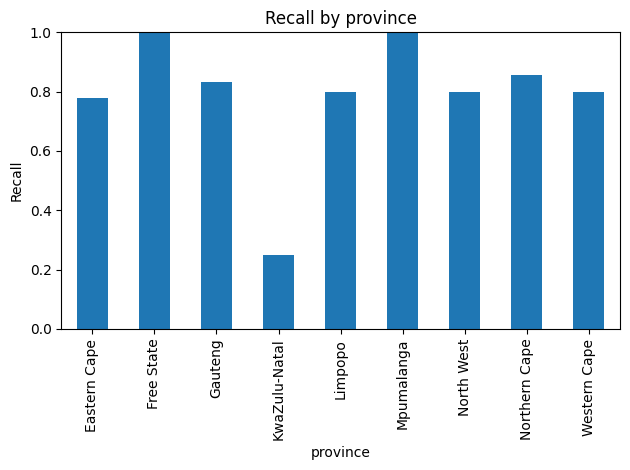

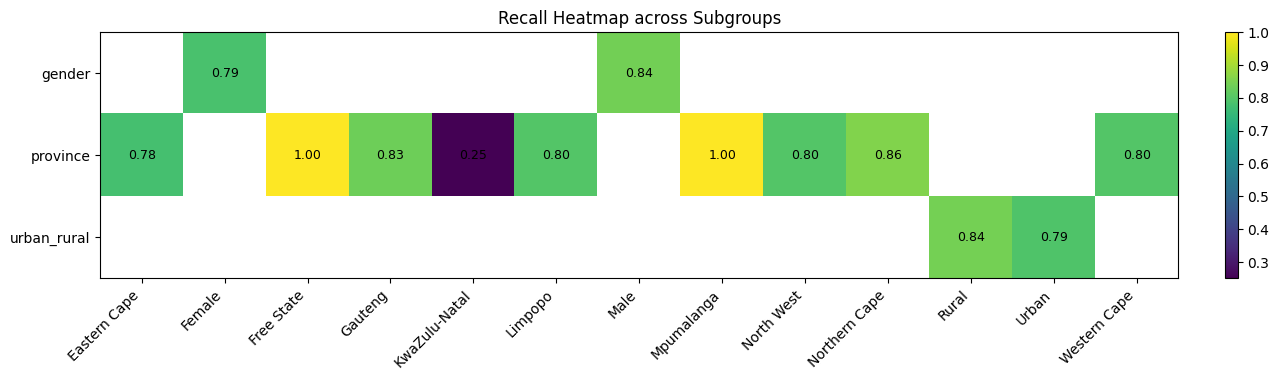

In [28]:
# Cell 5: Fairness charts (Recall by group, plus a heatmap of Recall)

def plot_grouped_bar(metric_df, group_col, metric="recall", title=None, fname=None):
    plt.figure()
    ax = metric_df.plot(kind="bar", x=group_col, y=metric, legend=False)
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.0)
    plt.title(title or f"{metric.capitalize()} by {group_col}")
    plt.tight_layout()
    plt.show()

def plot_recall_heatmap(tables_dict):
    # Build a single table of recalls
    rows = []
    for gcol, dfm in tables_dict.items():
        for _, r in dfm.iterrows():
            rows.append({"grouping": gcol, "group": r[gcol], "recall": r["recall"]})
    H = pd.DataFrame(rows)
    if H.empty:
        print("No fairness tables to plot.")
        return
    pivot = H.pivot(index="grouping", columns="group", values="recall")
    plt.figure(figsize=(max(6, 1.0 * pivot.shape[1]), 3 + 0.3*pivot.shape[0]))
    im = plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.title("Recall Heatmap across Subgroups")
    # annotate
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.values[i, j]
            if pd.notnull(val):
                plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)
    plt.tight_layout()
    plt.show()

# Plot recall by each grouping and the heatmap
for gcol, dfm in fairness_tables.items():
    plot_grouped_bar(
        dfm, gcol, metric="recall",
        title=f"Recall by {gcol}",
    )

plot_recall_heatmap(fairness_tables)



In [29]:
# Cell 6: Auto-generate a short findings summary (Markdown-friendly)

# Identify top global features from SHAP (recompute summary stats if needed)
top_features = []
if 'explanation' in globals() and explanation is not None and not use_legacy:
    mean_abs = np.mean(np.abs(explanation.values), axis=0)
    order = np.argsort(-mean_abs)
    top_features = [explanation.feature_names[i] for i in order[:5]]
else:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval)
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    order = np.argsort(-mean_abs)
    top_features = [X_eval.columns[i] for i in order[:5]]

def best_and_worst_groups(tbl):
    # Return group with highest and lowest recall (if available)
    if tbl is None or len(tbl) == 0:
        return None, None
    t = tbl.dropna(subset=["recall"])
    if len(t) == 0:
        return None, None
    hi = t.iloc[t["recall"].idxmax()]
    lo = t.iloc[t["recall"].idxmin()]
    return (hi.iloc[0], hi["recall"]), (lo.iloc[0], lo["recall"])

lines = []
lines.append("### Findings Summary (for Application Section)\n")
# Overall metrics — if you already computed, you can bring in your AUC/PR/etc. Here we compute AUC on test quickly:
overall_auc = roc_auc_score(y_test, y_proba)
lines.append(f"- **Overall AUC (test)**: {overall_auc:.3f}")

# SHAP global
lines.append(f"- **Top global features (SHAP)**: {', '.join(top_features[:5])}")

# Fairness highlight
for gcol in ["gender", "urban_rural", "province"]:
    if gcol in fairness_tables:
        hi, lo = best_and_worst_groups(fairness_tables[gcol])
        if hi and lo:
            lines.append(
                f"- **Recall disparity by {gcol}**: best = `{hi[0]}` ({hi[1]:.2f}), worst = `{lo[0]}` ({lo[1]:.2f})."
            )

summary_text = "\n".join(lines)
print(summary_text)


### Findings Summary (for Application Section)

- **Overall AUC (test)**: 0.959
- **Top global features (SHAP)**: attendance, age, parent_education, household_income, highest_grade
- **Recall disparity by gender**: best = `Male` (0.84), worst = `Female` (0.79).
- **Recall disparity by urban_rural**: best = `Rural` (0.84), worst = `Urban` (0.79).
- **Recall disparity by province**: best = `Free State` (1.00), worst = `KwaZulu-Natal` (0.25).


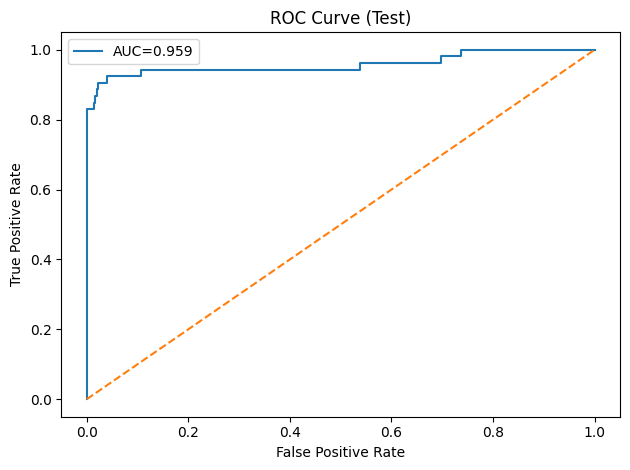

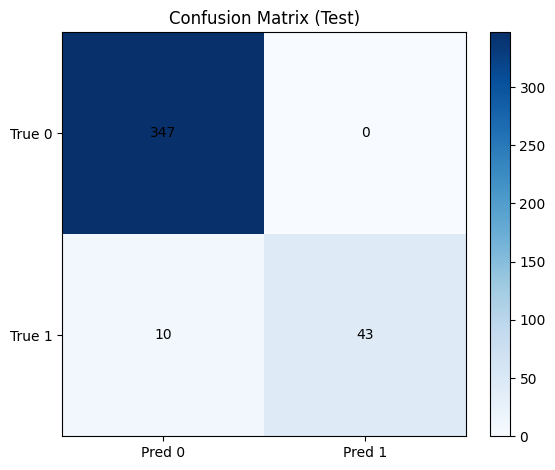

Saved: roc_curve.png, confusion_matrix.png


In [30]:

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
im = plt.imshow(cm, cmap="Blues")
plt.colorbar(im, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

print("Saved: roc_curve.png, confusion_matrix.png")
